In [8]:
# Fill in your name using the format below and student ID number
your_name = "Er, Esref"
student_id = "1068926"

In [9]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [10]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [11]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [13]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Esref, Looks good. You may continue :)


In [14]:
#Imports needed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

import cv2

import os.path

from PIL import Image

import pickle

import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import model_from_json



# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [15]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [16]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [17]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [18]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [19]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [20]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

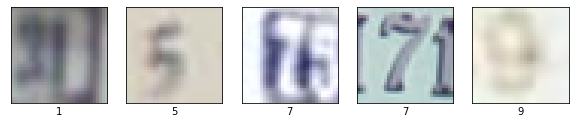

In [21]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [22]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
  """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
  function following the Keras API. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  try:
    # if a json description is available, load config and then weights
    if os.path.isfile(os.path.join(base_dir, name+'.json')):
      json_file = open(os.path.join(base_dir, name+'.json'), 'r')
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json)
      model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
    else:
      model = load_model(os.path.join(base_dir, name+extension))
  except OSError:
    shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
    return False
  return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
  """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
  adapt as needed. 
  Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
  """
  path = os.path.join(base_dir, name+extension)
  model.save(path)
  size = os.path.getsize(path)
  # If model > 100MB, store the weights and architecture only.
  if size > 100*1024*1024:
    print("Model larger than 100MB, storing weights only.")
    model.save_weights(path)
    model_json = model.to_json()
    with open(os.path.join(base_dir, name+".json"), "w") as json_file:
        json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_51 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_211 (Dense)            (None, 128)               393344    
_________________________________________________________________
dense_212 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_213 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_214 (Dense)            (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.524492  0.430033  0.

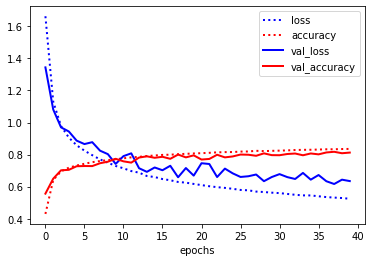

In [23]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=40, batch_size=32)

In [24]:
answer_q_1_1 = """
I started with a dense layer of 32 neurons and iteratively added a dense layer with twice the neurons until the network stopped underfitting.
I chose ELU since it is not too sensitive to vanishing gradients and removes the dying ReLU problem.
I tried all default Keras optimizers, and Nadam worked best.
I chose softmax as activation function in the output layer, since it works well with categorical_crossentropy.
The network works quite well, but starts overfitting after 15 epochs.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

Answer is 486 characters long


### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [25]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_153 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_154 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_155 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_156 (Dense)            (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.527624  0.446604  0.

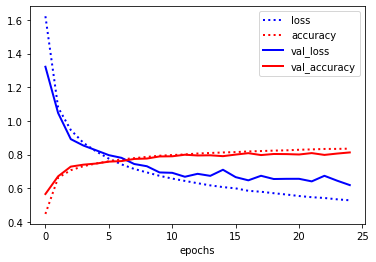

In [26]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train),  rgb2gray(X_val),  y_train,  y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=25, batch_size=32)

In [27]:
answer_q_1_2 = """
Data is lost by converting the images to greyscale. This shrinks the input shape from (32,32,3) to (32,32,1).
Data may be lost, but color is not important when it comes to catogoraizing images of numbers.
The first few epochs have the biggest difference in accuracy. The model learns faster, since there is less 'noise' in the data. 
As a result, the model requires less epochs to get the same accuracy from the previous model, making it a better model.
However, it starts to overfit earlier.
"""

print("Answer is {} characters long".format(len(answer_q_1_2)))

Answer is 494 characters long


### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_46 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_189 (Dense)            (None, 128)               131200    
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_190 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_191 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_35 (Dropout)

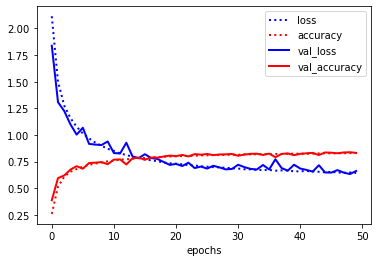

In [28]:
def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001 / 10),activation='elu'))
    model.add(layers.Dropout(0.3 / 10))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001 / 10), activation='elu'))
    model.add(layers.Dropout(0.4 / 10))
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001 / 10), activation='elu'))
    model.add(layers.Dropout(0.5 / 10))
    model.add(layers.Dense(10,activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=128)

In [29]:
answer_q_1_3 = """
The base amount of layers/neurons has not been adjusted due to the build-up strategy of 1.1.
I did a gridsearch to determine the regularizer and regularizer factor.
I tried batch normalization, but the network got worse.
Gradually increasing the amount of dropout rate worked best. This forces layers deep in the model to regularize more.
It is recommended to use default values for Nadam.
The generalization performance of the network has improved, resulting in higher overall accuracy on X_val.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

Answer is 498 characters long


## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_121 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_122 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D) 

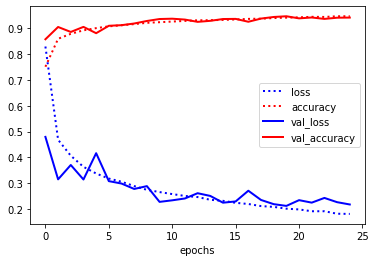

In [30]:
def build_model_2_1():
    model = models.Sequential()
    
    #Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4)) 

    #Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))
    
    #Final Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    
    #Output Layer
    model.add(layers.Dense(10, activation='softmax'))
    
    rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=True)

    model.compile(optimizer=rms,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=25, batch_size=32)


In [31]:
answer_q_2_1 = """
The number of filters learning is increasing as the output spatial volume is decreasing. 
I have done this, since it is a common practice in designing CNN architectures. 
After every two Conv2d there is a Max Pooling layer, since more convolution before reducing the size can lead to more interesting representations of the data, and improve the accuracy. 
A kernel size of 3x3 is chosen, since the input is small. 
Gradually increasing the amount of dropout rate worked best. This forces layers deep in the model to regularize more.
The network converged more quickly and trained faster with the use of batch normalization.
A final fully conntected layer is added, since this is common practive and increased the accuracy. 
The model works well, but starts slightly overfitting after 20 epochs.
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

Answer is 797 characters long


### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_126 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_127 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D) 

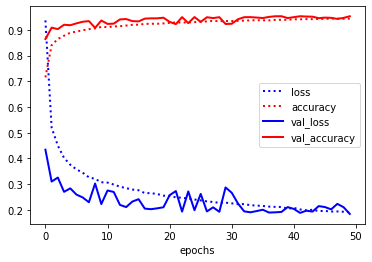

In [32]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

train_datagen = ImageDataGenerator(
rotation_range=10,
width_shift_range=1.1,
height_shift_range=1.1,
zoom_range=[0.9,1.1],
rescale=1.1
)
train_it = train_datagen.flow(preprocessed_split[0], y_train, batch_size=64)
augmented_split = (train_it,  preprocessed_split[1],  y_val)

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, epochs=50, batch_size=None, generator=True,steps_per_epoch=len(preprocessed_split[0])/64)


In [33]:
answer_q_2_2 = """
The validation accuracy is much higher than the training accuracy in the first 30 epochs.
This is probably due to the fact that the train data contains more 'difficult' data to learn.
We get the best results with very subtle data augmentation (small shifts, rotations, zooms and rescales), 
because the images are low resolution and too many editing results in too much information loss.
Flipped images do not appear in the data set, so they cause noise.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

Answer is 456 characters long


## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [34]:
model = load_model_from_file(base_dir, 'model_2_2')
model._make_predict_function()
y_pred = model.predict(rgb2gray(X_test))
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
cifar_classes = {0: "One", 1: "Two", 2: "Three", 3: "Four", 4: "Five",
             5: "Six", 6: "Seven", 7: "Eight", 8: "Nine", 9: "Zero"}
test_accuracy_3_1 = model.evaluate(rgb2gray(X_test), y_test)[1]

def plot_confusion_matrix():

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
    ax.set_yticklabels(list(cifar_classes.values()))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")
        
def plot_misclassifications():
    fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    hoi = 1
    index = 0
    for nr, i in enumerate(misclassified_samples):
        if cifar_classes[np.argmax(y_pred[i])] == "Six" and cifar_classes[np.argmax(y_test[i])] == "Three":
            axes[index].imshow(X_test[i])
            axes[index].set_xlabel("Predicted: %s,\n Actual : %s" % (cifar_classes[np.argmax(y_pred[i])],cifar_classes[np.argmax(y_test[i])]))
            axes[index].set_xticks(()), axes[index].set_yticks(())
            index = index + 1
        if index > 4:
            break

    plt.show();



19858/19858 [==============================] - 4s 182us/sample - loss: 0.1859 - accuracy: 0.9527


In [35]:
answer_q_3_1 = """
The accuracy on the test set was about 95%.
You can see from the confusion matrix that the numbers that are confused with each other often look alike. Take 1 and 7 for example.
It can also be seen that numbers with simple shapes such as 1 are often confused with others.
I've researched images predicted 6 but are actual a 3, since they don't look alike.
These confusions are usually due to poor photo quality, background noises and weird typography.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

Answer is 452 characters long


### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [36]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(rgb2gray(X_test))

def plot_activation(layer_index, activations):
    images_per_row = 16

    layer_names = []
    for layer in model.layers:
        layer_names.append(layer.name)
    
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

    
def plot_activations():
    plot_activation(0, activations)
    plot_activation(2, activations)
    plot_activation(6, activations)
    plot_activation(8, activations)


In [37]:
answer_q_3_2 = """
The first 2 convolution layers are various edge detectors. 
There are alot of empty filter activation in the first convolution layer, this happends when the input image does not have the information that the filter was interested in. 
Within the 3rd convolution layer it can be seen that the activations are becoming more and more abstract. 
The filter is activating on for example: the top/bottom part of the 8 and also the two holes.
The activations on the last layer become even more abstract. 
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

Answer is 499 characters long


### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


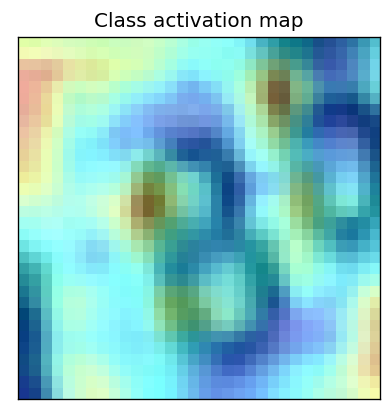

In [38]:
tf.compat.v1.disable_eager_execution()

def plot_3_3():
    model = load_model_from_file(base_dir, 'model_2_2')
    # `x` is a float32 Numpy array of shape (224, 224, 3)
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x, axis=0)

    african_elephant_output = model.output[:,7]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer = model.get_layer('conv2d_106')

    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    preds = model.predict(x)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img =  X_test[0]*255

    cv2.imwrite('original_image_3_3.jpg', img)
    
    # We use cv2 to load the original image
    img = cv2.imread('original_image_3_3.jpg')

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img

    # Save the image to disk
    cv2.imwrite('heatmap_image_3_3.jpg', superimposed_img)

    img = cv2.imread('heatmap_image_3_3.jpg')
    RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.dpi'] = 120
    plt.imshow(RGB_im)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

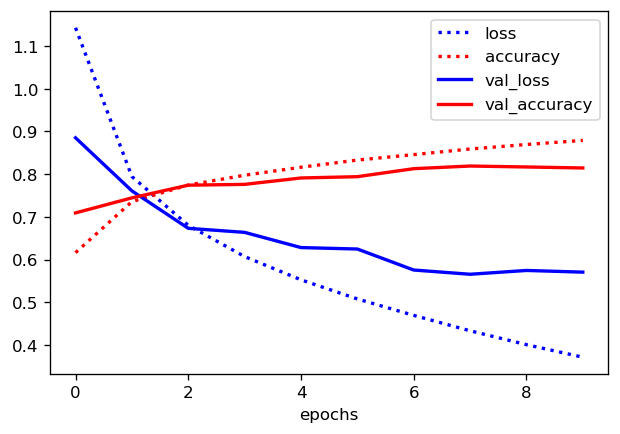

In [39]:
def build_model_4_1():
    conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3),
                 pooling='max')
    conv_base.summary()
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))  
    model.add(layers.Dense(10, activation='softmax'))
    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    rms = optimizers.RMSprop(learning_rate=0.00002, rho=0.9, momentum=0.0, epsilon=1e-07, centered=True)

    model.compile(optimizer=rms,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=False, epochs=10, batch_size=64)

In [40]:
answer_q_4_1 = """
We get very poor performance when we use the fast feature extraction method.
Fine-tuning works better, with the last block (block5_conv1) being unfreezed, but it starts heavily overfitting after 6 epochs.
The accuracy on the validation set does not exceed 82%.
VVG16 model is made to classify 1000 different objects in the imagenet dataset, not including numbers.
Our network is performing better, we can conclude that VVG16 is not the network to use for this case.
"""
print("Answer is {} characters long".format(len(answer_q_4_1)))

Answer is 467 characters long


### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [46]:
def mapping(y):
    """ To integers
    """
    mapping = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
    
    result = []
    
    for i in y:
        result.append(mapping[np.argmax(i)])
        
    return result


def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model = load_model_from_file(base_dir, 'model_4_1')
    model._layers.pop()
    model._layers.pop()
    model._layers.pop()
    store_embedding(model.predict(X_train), 'Train')
    store_embedding(model.predict(X_test), 'Test')
    store_embedding(model.predict(X_val), 'Validation')

def generate_pipeline():
  """ Returns an sklearn pipeline.
  """
  return make_pipeline(StandardScaler(),  RandomForestClassifier(n_estimators=250, max_features=0.05))

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    pipeline.fit(X_train, mapping(y_train))
    
    y_pred = pipeline.predict(X_test)
    return accuracy_score(mapping(y_test), y_pred)

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    validation = load_embedding('Validation')
    train = load_embedding('Train')
    test = load_embedding('Test')

    pipeline = generate_pipeline()
    
    #Test
    accuracy = evaluate_pipeline(pipeline, train, train, test, y_test)

    return accuracy

evaluation_4_2(X_train, y_train, X_test, y_test)

0.8125692416154698

In [42]:
answer_q_4_2 = """
I loaded the network from 4_2 and popped the dense layers off.
Then I made several pipelines with different classifiers. Including RandomForest, LogisticRegression and SupportVector.
I did a grid search for each classifier for the relevant parameters.
Random forest came out best in the tests, although they were all very similar in accuracy.
The accuracy is (almost) the same as 2_2, but no better than 4_2.
"""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Answer is 410 characters long
